# Spectrum simulation for CTA

A quick example how to simulate and fit a spectrum for the [Cherenkov Telescope Array (CTA)](https://www.cta-observatory.org)

We will use the following classes:

* [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumSimulation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumSimulation.html)
* [gammapy.spectrum.SpectrumFit](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumFit.html)
* [gammapy.scripts.CTAIrf](http://docs.gammapy.org/en/latest/api/gammapy.scripts.CTAIrf.html)

This tutorial is work in progress. See [GH issue 742](https://github.com/gammapy/gammapy/issues/742) for status and discussions.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import numpy as np
import astropy.units as u
from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumSimulation, SpectrumFit
from gammapy.spectrum.models import PowerLaw
from gammapy.scripts import CTAIrf

## Simulation

In [3]:
# Define obs parameters
livetime = 1 * u.h
# TODO: there's a problem with the CTA IRFs:
# At 0.5 deg, no EDISP is present.
offset = 3 * u.deg
# offset_aeff = 0.5 * u.deg
lo_threshold = 0.1 * u.TeV
hi_threshold = 60 * u.TeV

In [4]:
# Load IRFs


# This works, it's the example from the "simulating spectra" docs page.
# TODO: remove once the CTA IRF simulations here are working well.
# e_true = np.logspace(-2, 2.5, 109) * u.TeV
# e_reco = np.logspace(-2,2, 79) * u.TeV
# edisp = EnergyDispersion.from_gauss(e_true=e_true, e_reco=e_reco, sigma=0.2)
# aeff = EffectiveAreaTable.from_parametrization(energy=e_true, instrument='CTA')

filename = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/South_5h/irf_file.fits.gz'
cta_irf = CTAIrf.read(filename)

EffectiveAreaTable2D summary info
energy         : size =   501, min =  0.005 TeV, max = 501.187 TeV
offset         : size =    45, min =  0.100 deg, max =  4.500 deg
Data           : size = 22500, min =  0.000 m2, max = 4033200.000 m2



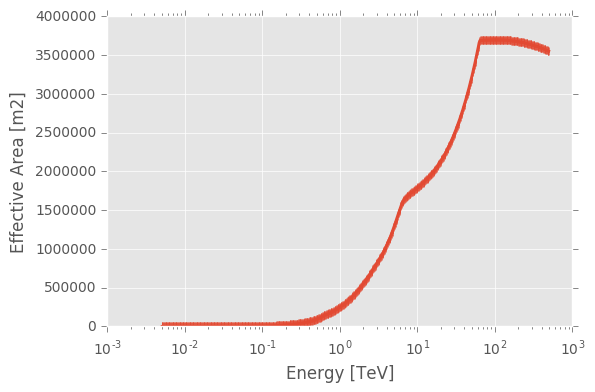

In [5]:
print(cta_irf.aeff)
aeff = cta_irf.aeff.to_effective_area_table(offset=offset)
aeff.plot()

EnergyDispersion summary info
e_true         : size =   501, min =  0.005 TeV, max = 501.187 TeV
e_reco         : size =   501, min =  0.005 TeV, max = 501.187 TeV
Data           : size = 250000, min =  0.000, max =  0.007



/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


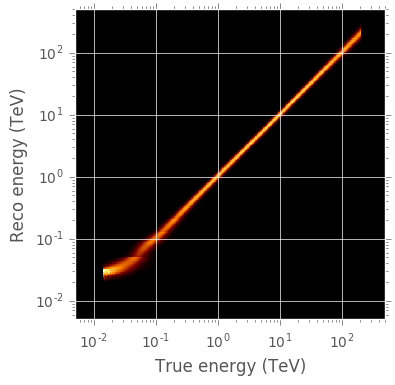

In [6]:
print(cta_irf.edisp)
# Slicing out the EDISP for a given offset is very slow.
# TODO: investigate and fix.
edisp = cta_irf.edisp.to_energy_dispersion(offset=offset)
edisp.plot_matrix()
print(edisp)

In [7]:
# Define spectral model
index = 2.3 * u.Unit('')
amplitude = 2.5 * 1e-11 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV
model = PowerLaw(index=index, amplitude=amplitude, reference=reference)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


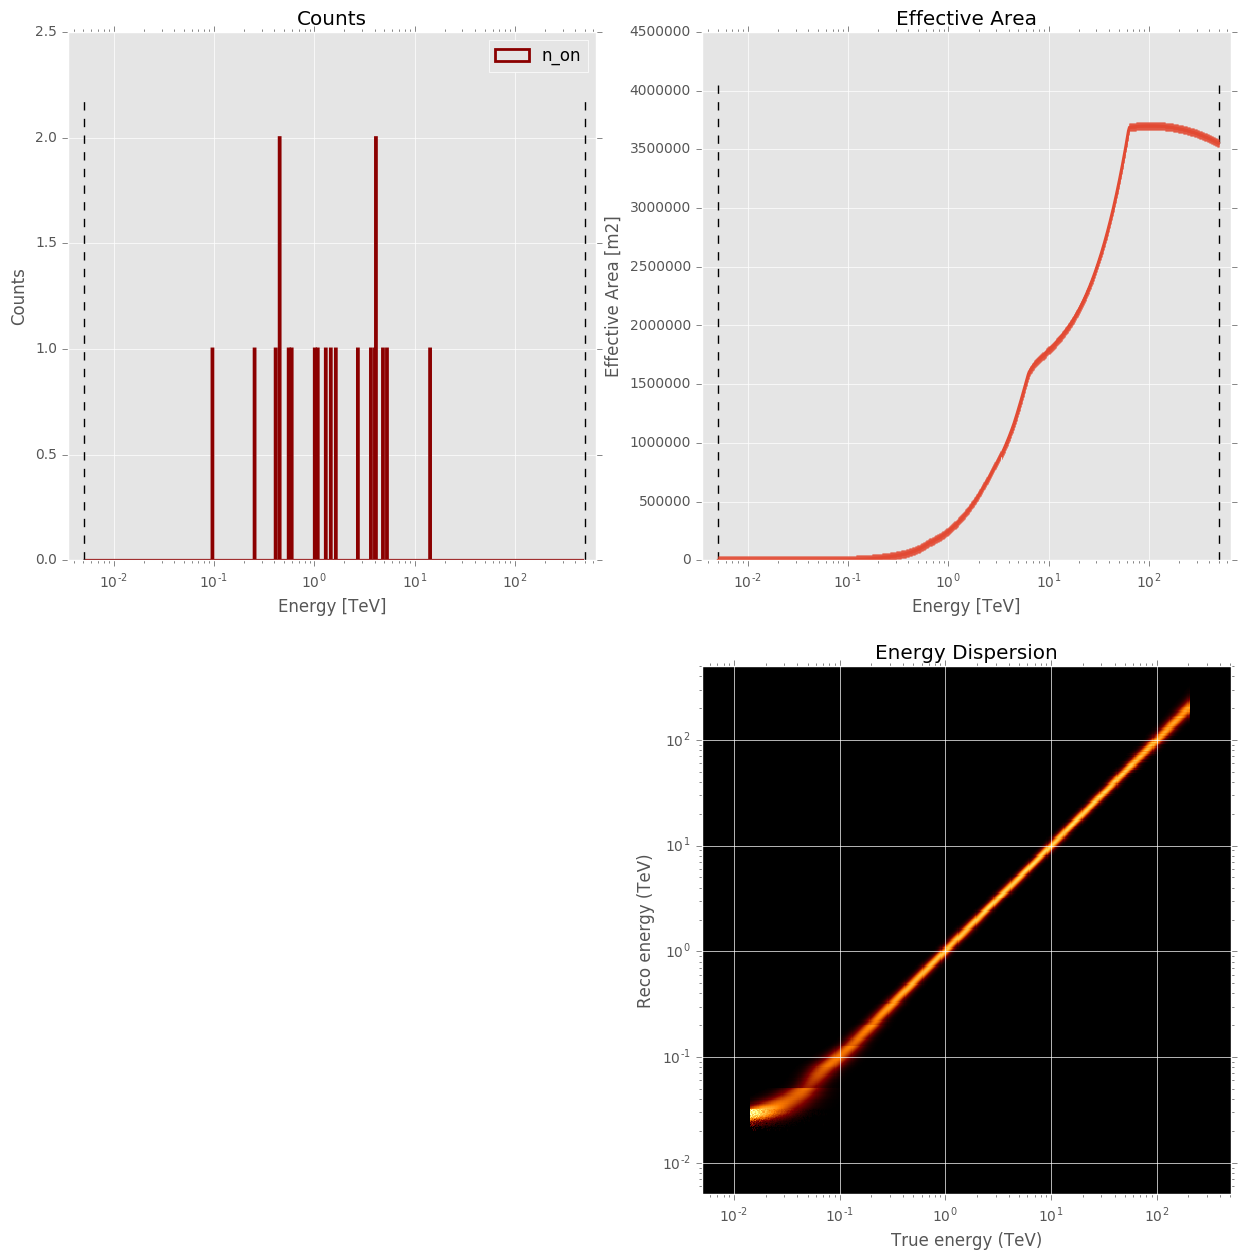

In [8]:
# Simulate data
aeff.lo_threshold = lo_threshold
aeff.hi_threshold = hi_threshold
# TODO: we only get counts if we make the source super bright.
# Looks like AEFF is in `m^2` here, and SpectrumSimulation uses `.data` and assumes `cm^2`?
sim = SpectrumSimulation(aeff=aeff, edisp=edisp, model=model, livetime=livetime)
obs = sim.simulate_obs(seed=42)
obs.on_vector.obs_id = 42
# obs.on_vector.lo_threshold = lo_threshold
# obs.on_vector.hi_threshold = hi_threshold
obs.peek();
# TODO: printing obs doesn't work because off_vector is None
# print(obs)

## Spectral analysis

Now that we have some simulated CTA counts spectrum, let's analyse it.

In [9]:
# Fit data
fit = SpectrumFit(obs_list=[obs], model=model)
fit.statistic = 'cstat'
fit.run()
result = fit.result[0]

In [10]:
print(result)


Fit result info 
--------------- 
Model: PowerLaw
amplitude : (2.28+/-0.52)e-07
index : 2.19+/-0.13
reference : 1 

Statistic: 104.428 (cstat)
Covariance:
['index', 'amplitude']
[[  1.75788575e-02   1.27130226e-09]
 [  1.27130226e-09   2.68639828e-15]]
Fit Range: [  5.07024300e-03   4.95483027e+02] TeV



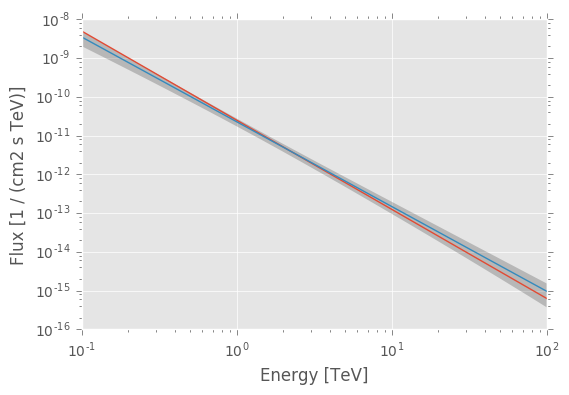

In [11]:
energy_range = [0.1, 100] * u.TeV
model.plot(energy_range=energy_range)
result.model.plot(energy_range=energy_range)
result.butterfly().plot(energy_range=energy_range)

So there you go. Gammapy can simulate and analyse CTA data.

:-)

That said, both Gammapy and the CTA IRF production are just getting started. If you have any questions, bug reports or feature requests for Gammapy, please let us know on the Gammapy mailing list or issue tracker (links are at http://docs.gammapy.org/)

## Exercises

* Play with the observation parameters:
  * Change the observation time to something longer or shorter. Does the observation and spectrum results change as you expected?
  * Change the field of view offset of the obsevation (TODO: what values do / don't work?)
  * Change the spectral model, e.g. add a cutoff at 5 TeV, or put a steep-spectrum source with spectral index of 4.0
* Use a simple leptonic or hadronic model from Naima for the simulation and / or fitting.

In [12]:
# Start the exercises here!

## What next?

In this tutorial we simulated a spectral observation using CTA prod 2 IRFs.

Here's some suggestion what to look at next:
* TODO: make tutorial with survey image simulation for CTA
* TODO: link to other tutorials on source detection or spectral analysis